In [1]:
import torch
import torch.nn as nn
from collections import namedtuple

/home/ubuntu/miniconda3/envs/env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [222]:
class ExpressionGenerator(nn.Module):
    """
    The generator for facial expression change shares the same architecture and weights with the mask branch of head generator.
    """
    def __init__(self, mask_layer):
        super(ExpressionGenerator, self).__init__()
        self.Mask = mask_layer
        

    def forward(self, x, pose_vector):
        return self.Mask(x, pose_vector)
        

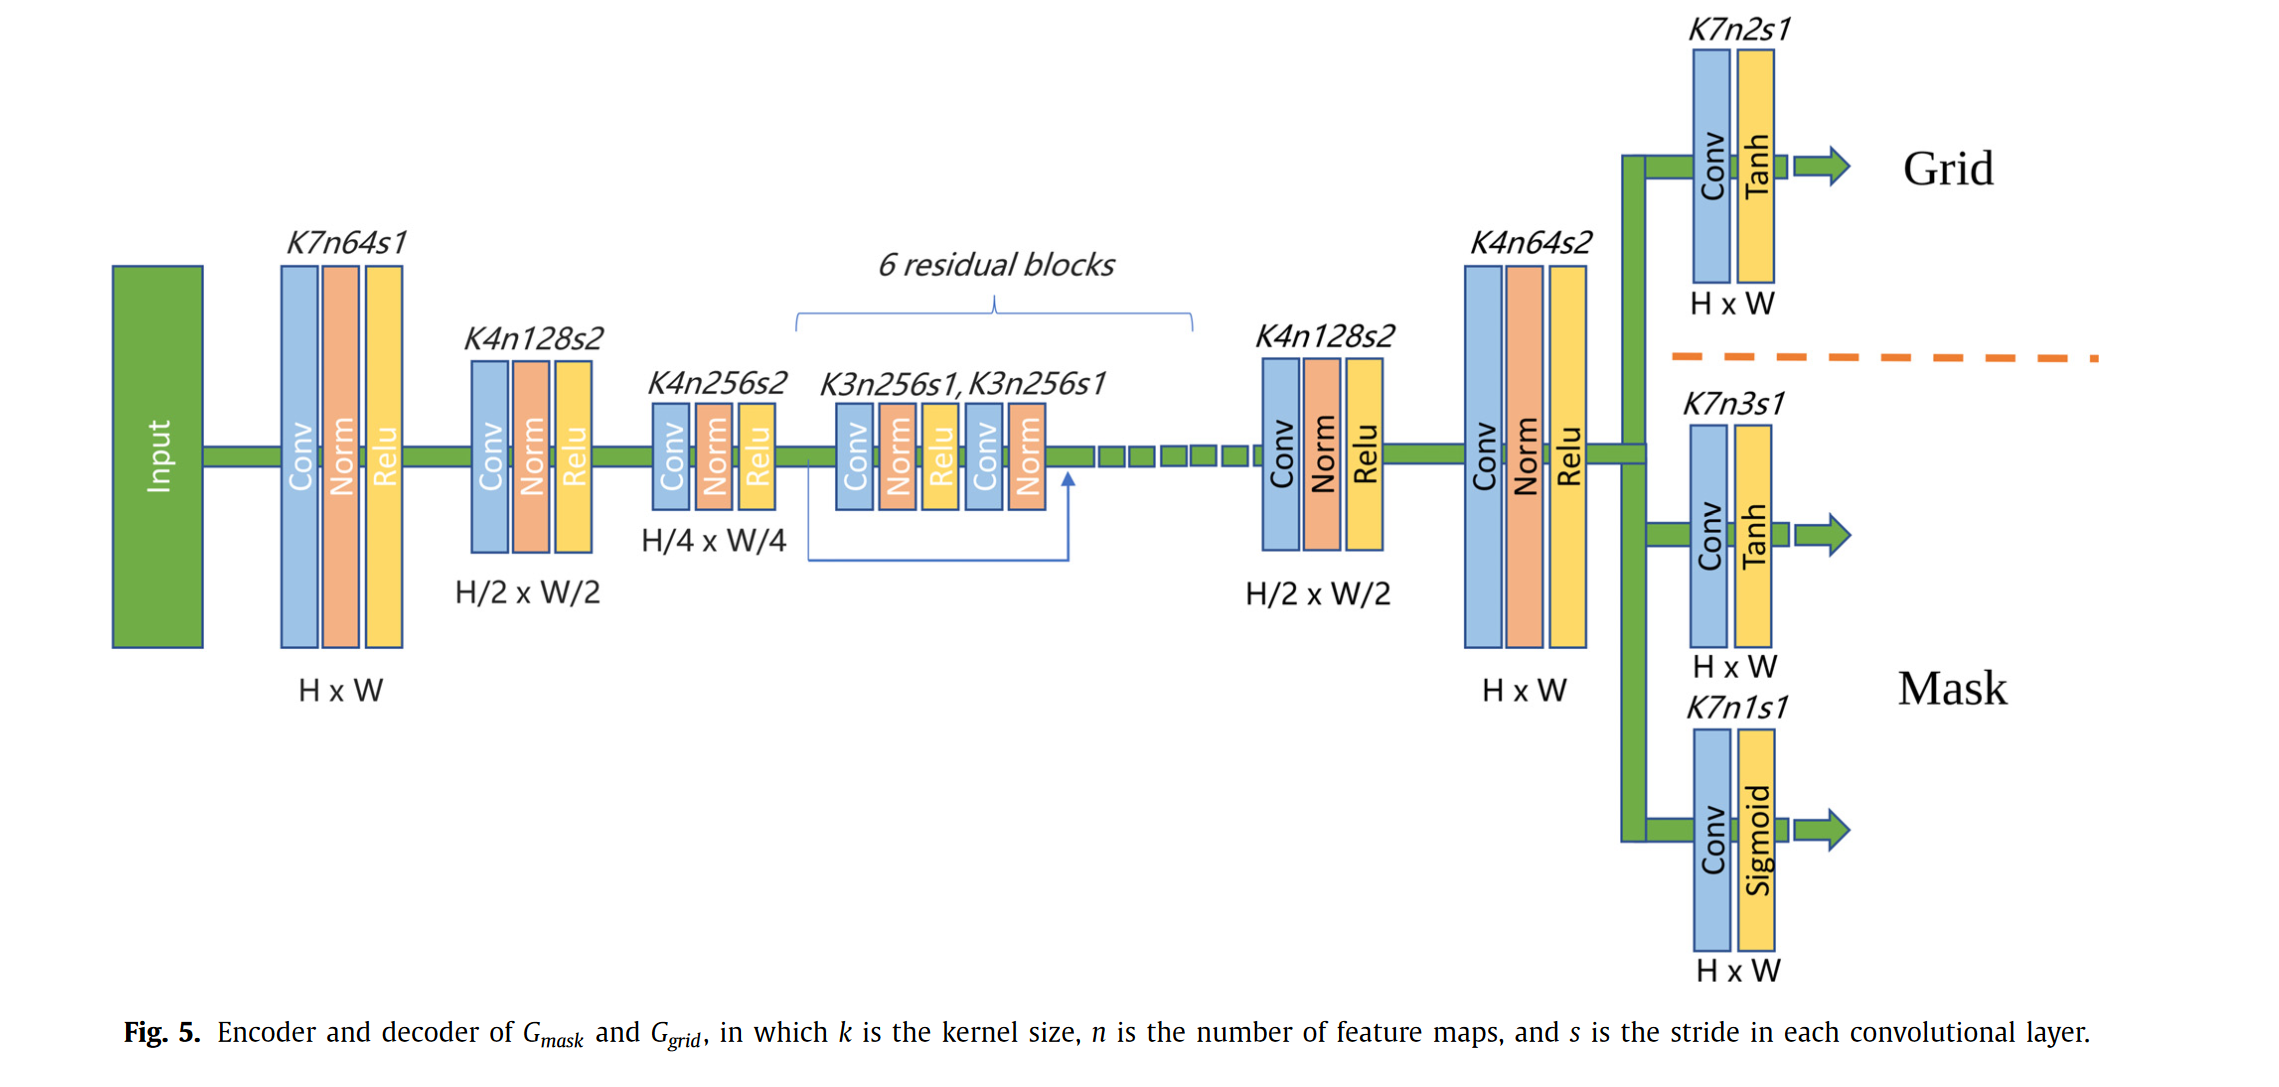

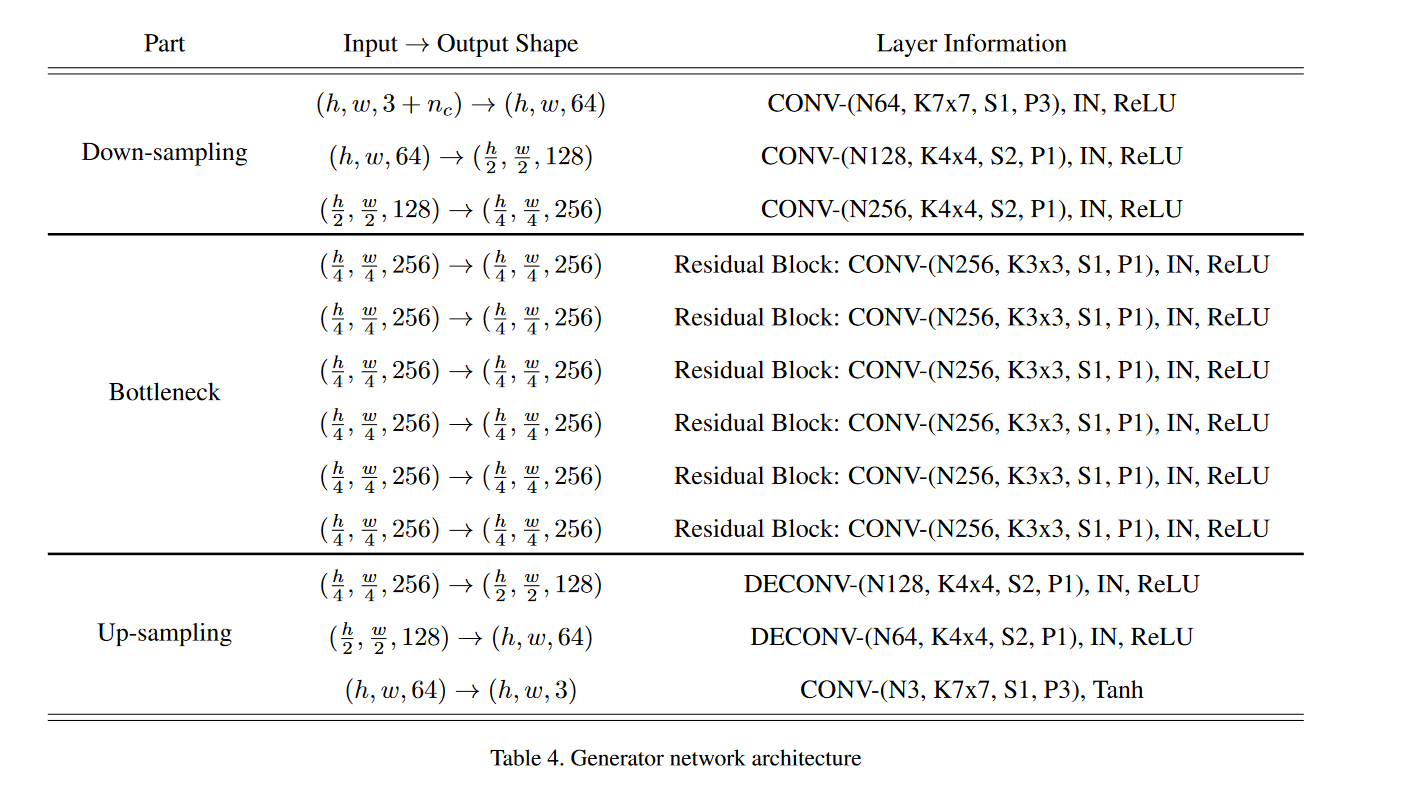

In [223]:
class MaskGenerator(nn.Module):
    """
    The generator for mask branch of head generator.
    """
    def __init__(self, shared_layer, H, W):
        super(MaskGenerator, self).__init__()
        self.shared = shared_layer
        # H/2 x W/2, K4n128s2 upsample + IN + ReLU
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True)
        )
        # H x W, K4n64s2 upsample + IN + ReLU
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # H x W, K7n3s1 conv + Tanh
        self.upC = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )
        # H x W, K7n1s1 conv + sigmoid
        self.upA = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=7, stride=1, padding=3),
            nn.Sigmoid()
        )

        

    def forward(self, x):
        x = self.shared(x)
        x = self.up1(x)
        x = self.up2(x)
        xC = self.upC(x)
        xA = self.upA(x)
        return xA, xC

In [224]:
class GridGenerator(nn.Module):
    """
    The generator for grid branch of head generator.
    """
    def __init__(self, shared_layer):
        super(GridGenerator, self).__init__()
        self.shared = shared_layer
        # H/2 x W/2, K4n128s2 upsample + IN + ReLU
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True)
        )
        # H x W, K4n64s2 upsample + IN + ReLU
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # H x W, K7n2s1 conv + Tanh
        self.up3 = nn.Sequential(
            nn.Conv2d(64, 2, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )
        

    def forward(self, x):
        x = self.shared(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        return x

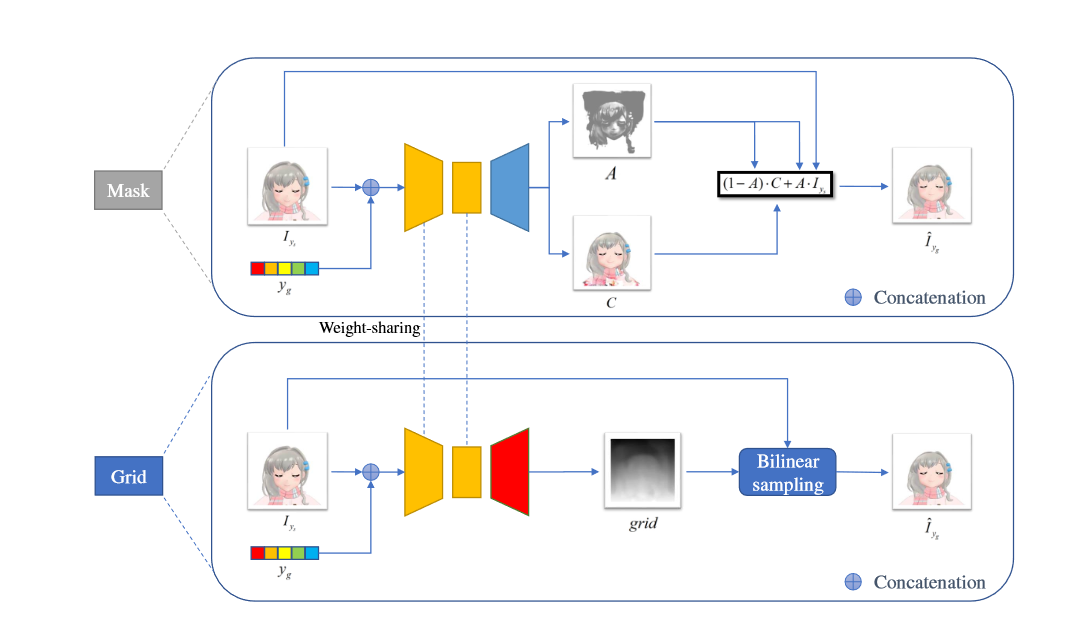

In [225]:
class Mask(nn.Module):
    """
    Given a single image Iys and a target pose vector yg, we first make a channel wise concatenation (Iys ,yg) as input of mask generator.
    Then the mask generator generates a single channel mask A and an RGB content C, where mask A is designed to guide the network to focus on the transforming pose-related regions.
    For instance, in the face stage,
    the only areas where the input image needs to be changed are the eyes and mouth, while the other areas are kept still, so the network only needs to generate the changed dynamic areas,
    the remaining static areas can be obtained directly from the input.
    Finally, the output image can be obtained as:
        ˆI_yg = (1 − A) · C + A · I_ys , (1)
    where · denotes element-wise multiplication.
    This strategy makes the learning process easier as the network only needs to focus on the dynamic areas, the static areas can be obtained from the input directly.
    However, mask generator is prone to be blurred, and it cannot maintain the color of input image well if given a large-scale pose vector.
    """
    def __init__(self, H, W, shared_layer):
        super(Mask, self).__init__()
        self.W = W
        self.H = H
        self.embed = nn.Embedding(6, W * H)
        self.G = MaskGenerator(shared_layer, self.H, self.W)

    def forward(self, x, pose_vector):
        # x: N x 3 x H x W
        # pose_vector: 1 x 6
        pose_vector = pose_vector.repeat(x.shape[0], 1)
        # pose_vector: N x 6
        pose_vector = self.embed(pose_vector.long())
        # pose_vector: N x 6 x (H x W)
        # print(pose_vector)
        pose_vector = pose_vector.view(x.shape[0], 6, self.H, self.W)
        # pose_vector: N x 6 x H x W
        # print(pose_vector.shape)
        
        x = torch.cat((x, pose_vector), dim=1)
        # x: N x 9 x H x W
        A, C = self.G(x)
        # A: N x 1 x H x W
        # C: N x 3 x H x W
        return (1 - A) * C + A * x[:, :3, :, :]
        

In [226]:
class Grid(nn.Module):
    """
    For the input image and target pose vector, we use the same way as the mask generator.
    The main difference is that the output of grid generator is a two-channel grid vector, not mask and content.
    We use the grid vector to synthesize target image by bilinear sampling from the input image, which is similar to appearance flow [8].
    The motivation of the grid generator is that bilinear sampling can make full use of the pixel information of the input image.
    The network only needs to generate a two-channel grid vectors to guide the sampling process from input image, rather than generating a complete RGB image,
    which significantly reduces the difficulty of learning process.
    """
    def __init__(self, H, W, shared_layer):
        super(Grid, self).__init__()
        self.W = W
        self.H = H
        self.embed = nn.Embedding(6, W * H)
        self.G = GridGenerator(shared_layer)
        self.BS = nn.functional.grid_sample
    def forward(self, x, pose_vector):
        # x: N x 3 x H x W
        # pose_vector: 1 x 6
        pose_vector = pose_vector.repeat(x.shape[0], 1)
        # pose_vector: N x 6
        pose_vector = self.embed(pose_vector.long())
        # pose_vector: N x 6 x (H x W)
        # print(pose_vector)
        pose_vector = pose_vector.view(x.shape[0], 6, self.H, self.W)
        # pose_vector: N x 6 x H x W
        x = torch.cat((x, pose_vector), dim=1)
        # x: N x 9 x H x W
        grid = self.G(x)
        # grid: N x 2 x H x W
        # print(grid.shape)
        grid = grid.permute(0, 2, 3, 1)
        # grid: N x H x W x 2
        y = self.BS(x[:, :3, :, :], grid, mode='bilinear', padding_mode='zeros')
        # y: N x 9 x H x W
        return y[:, :3, :, :]
        

In [227]:
class HeadMovementGeneratorMask(nn.Module):
    """
    The generator for head movement shares the same architecture and weights with the mask branch of head generator.
    pose vector is splitted
    The author introduce the pose vector decomposition and cascaded refinement strategy as shown in Fig. 3.
    Specifically, the author decompose large-scale pose vector of head movement into k small-scale pose vectors and pass them through k cascaded mask generators that share weights parameters.
    For instance, suppose the original large-scale pose vector is (0, 0, 0, 0, 1), we first transform the anime character to a target pose (0, 0, 0, 0, 1/k),
    then the pose (0, 0, 0, 0, 2/k) is generated based on the result of (0, 0, 0, 0, 1/k).
    This process repeats until (0, 0, 0, 0, 1) is reached.
    In practice, the author observed that k = 4 is sufficient to handle large-scale pose transforms.
    In this way, the mask generator can repeatedly perform small-scale transform to complete large-scale transform, which improves the final result.
    """
    def __init__(self, mask_layer, k=4):
        super(HeadMovementGeneratorMask, self).__init__()
        self.Mask = mask_layer
        self.k = k
        

    def forward(self, x, pose_vector):
        # x: N x 3 x H x W
        # pose_vector: 1 x 6
        for i in range(self.k):
            x = self.Mask(x, (i+1) * pose_vector / self.k)
        return x

In [228]:
class HeadMovementGeneratorGrid(nn.Module):
    def __init__(self, H, W, shared_layer):
        super(HeadMovementGeneratorGrid, self).__init__()
        self.grid = Grid(H, W, shared_layer)
        

    def forward(self, x, pose_vector):
        return self.grid(x, pose_vector)

In [229]:
class FusionGenerator(nn.Module):
    """
    The generator for fusion branch of head generator.
    G_fusion contains only two downsampling layers and two upsampling layers, and outputs a single-channel mask.
    """
    def __init__(self):
        super(FusionGenerator, self).__init__()
        self.down1 = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        )
        

    def forward(self, x):
        x = self.down1(x)
        x = self.down2(x)
        x = self.up1(x)
        x = self.up2(x)
        return x

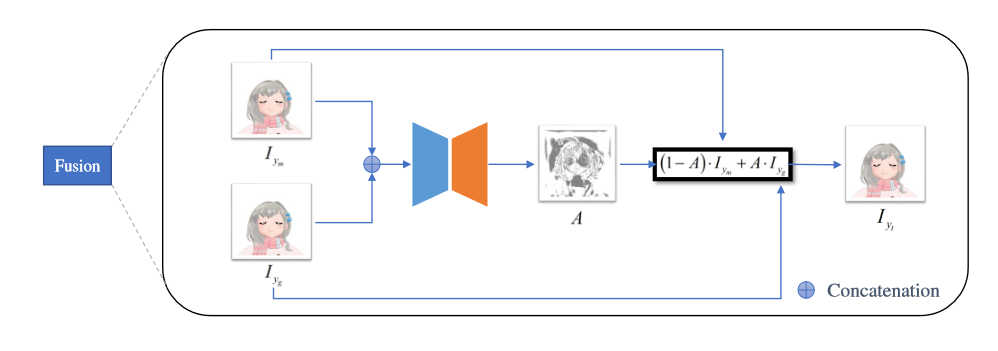

In [230]:
class Fusion(nn.Module):
    """
    The output I_ym of mask generator and the output I_yg of grid generator are made a concatenation as the input of fusion.
    The output of fusion is an attention mask A, which guides two source images to fuse to obtain the final result.
    Finally, the final image can be obtained as:
    ˆIyt = (1 − A) · I_ym + A · I_yg , (2)
    """
    def __init__(self):
        super(Fusion, self).__init__()
        self.G = FusionGenerator()
        

    def forward(self, x_mask, x_grid):
        # (N x 3 x H x W , N x 3 x H x W)
        # print(x_mask.shape, x_grid.shape)
        x = torch.cat((x_mask, x_grid), 1)
        # x: N x 6 x H x W
        A = self.G(x)
        # A: N x 1 x H x W
        return (1 - A) * x_mask + A * x_grid



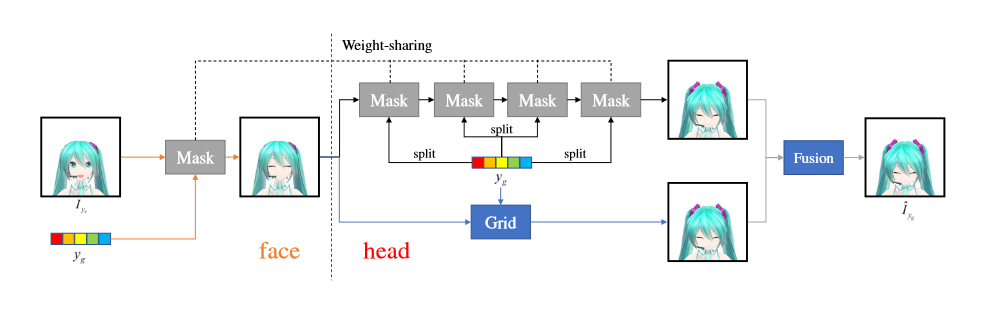

In [231]:
class ResBlock(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_size, hidden_size, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(hidden_size, out_size, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.in1 = nn.InstanceNorm2d(hidden_size)
        self.in2 = nn.InstanceNorm2d(out_size)

    def forward(self, x):
        y = self.relu(self.in1(self.conv1(x)))
        y = self.in2(self.conv2(y))
        return x + y
        

In [232]:
class CPTNet(nn.Module):
    """
    The author propose a two-stage CPTNet,
    that includes a generator for facial expression, a generator for head movement, and a light-weight combiner,
    for single image talking head animation.

    The generator for facial expression change shares the same architecture and weights with the mask branch of head generator.

    Mask generator and Grid generator:
    Given a single anime image and a target pose vector, 
    on one hand, the mask generator generates a single channel mask A and an RGB content image C.Then mask A linearly combines the source image and the content C to obtain the output.
    On the other hand, the grid generator generates a grid to get the output via bilinear sampling.
    """
    def __init__(self, H, W):
        super(CPTNet, self).__init__()
        self.shared_layer = nn.Sequential(
            # Down-sampling
            # N x 9 x H x W
            nn.Conv2d(9, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            # N x 64 x H x W
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            # N x 128 x H/2 x W/2
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),

            # Bottleneck
            # N x 256 x H/4 x W/4
            ResBlock(256, 256, 256),
            ResBlock(256, 256, 256),
            ResBlock(256, 256, 256),
            ResBlock(256, 256, 256),
            ResBlock(256, 256, 256),
            ResBlock(256, 256, 256),
        )
        self.Mask = Mask(H, W, self.shared_layer)  # Weight of the Mask model is shared
        self.EG = ExpressionGenerator(mask_layer=self.Mask)
        self.HMGM = HeadMovementGeneratorMask(mask_layer=self.Mask)
        self.HMGG = HeadMovementGeneratorGrid(H, W, self.shared_layer)
        self.Comb = Fusion()
        



    def forward(self, x, pose_vector):
        """
        x: input image
        pose_vector: 6-dim vector, [left eye, right eye, mouth, top-down head, left-right head]
        left eye, right eye, mouth: [0, 1]
        top-down head, left-right head: [-1, 1]
        """
        x = self.EG(x, pose_vector)
        x1 = self.HMGM(x, pose_vector)
        x2 = self.HMGG(x, pose_vector)
        x = self.Comb(x1, x2)
        return x

In [7]:
# load png as torch.tensor
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

img = Image.open('neuro.png')
img = img.convert('RGB')
transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # transforms.Normalize([.5, .5, .5], [.5, .5, .5])
])
a = transforms(img)

In [234]:
a

tensor([[[0.7843, 0.7961, 0.7686,  ..., 0.8902, 0.8824, 0.8980],
         [0.7804, 0.7490, 0.6784,  ..., 0.8980, 0.8941, 0.8980],
         [0.7098, 0.6078, 0.5373,  ..., 0.9020, 0.9020, 0.8980],
         ...,
         [0.7804, 0.7765, 0.7843,  ..., 0.8118, 0.8078, 0.7961],
         [0.7647, 0.7961, 0.8000,  ..., 0.8039, 0.8118, 0.8235],
         [0.7686, 0.7882, 0.7882,  ..., 0.8157, 0.8196, 0.8235]],

        [[0.4392, 0.4667, 0.4627,  ..., 0.6353, 0.6275, 0.6431],
         [0.4510, 0.4353, 0.3804,  ..., 0.6431, 0.6392, 0.6431],
         [0.4078, 0.3098, 0.2471,  ..., 0.6471, 0.6431, 0.6431],
         ...,
         [0.3647, 0.3608, 0.3686,  ..., 0.4157, 0.4078, 0.4000],
         [0.3529, 0.3804, 0.3843,  ..., 0.4078, 0.4118, 0.4275],
         [0.3529, 0.3725, 0.3725,  ..., 0.4157, 0.4196, 0.4275]],

        [[0.5765, 0.5961, 0.5843,  ..., 0.7216, 0.7137, 0.7294],
         [0.5804, 0.5569, 0.4980,  ..., 0.7294, 0.7255, 0.7294],
         [0.5255, 0.4275, 0.3608,  ..., 0.7333, 0.7294, 0.

In [235]:
# show a
def show(a):
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.imshow(a.transpose(0, 2).transpose(0, 1))
    plt.show()

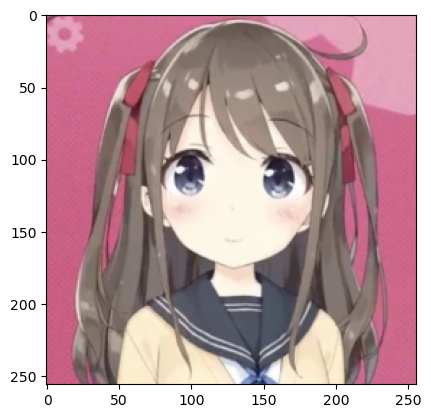

In [236]:
show(a)

In [237]:
G = CPTNet(256, 256)

In [8]:
a = a.unsqueeze(0)
a.shape

torch.Size([1, 3, 256, 256])

In [242]:
y = G(a, torch.tensor([1,1,1,0,0,1])).detach()
y = y.squeeze(0)
y.shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


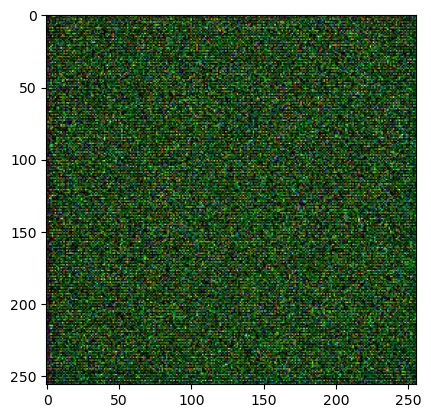

In [243]:
show(y)

In [1]:
class StarGANDiscriminator(nn.Module):
    def __init__(self, H, W):
        self.H = H
        self.W = W
        # H x W x 3
        self.input = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.01, inplace=True)
        )
        # H/2 x W/2 x 64
        self.hidden = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.01, inplace=True)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.01, inplace=True)
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.01, inplace=True)
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.01, inplace=True)
            nn.Conv2d(1024, 2048, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.01, inplace=True)
        )
        # H/64 x W/64 x 2048
        self.output = nn.Sequential(
            
        )

NameError: name 'nn' is not defined

In [2]:
class LossNetwork(nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        # extract the features of conv1 1, conv2 1, conv3 1, and conv4 2
        self.layer_name_mapping = {
            '1': "relu1_1",
            '6': "relu2_1",
            '11': "relu3_1",
            '22': "relu4_2"
        }
        self.LossOutput = namedtuple("LossOutput", ["relu1_1", "relu2_1", "relu3_1", "relu4_2"])

    def forward(self, x):
        """
        x: N x 3 x H x W
        """
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return self.LossOutput(**output)


In [5]:
import torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VGG = torchvision.models.vgg19(pretrained=True)
VGG = VGG.to(device)
loss_network = LossNetwork(VGG)
loss_network.eval()

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [16]:
loss_network(a.to(device))

LossOutput(relu1_1=tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0033, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 1.0047, 1.0335,  ..., 1.2189, 1.1825, 2.2614],
          [0.0000, 0.2493, 0.2683,  ..., 0.3633, 0.3384, 2.1790],
          [0.0000, 0.2834, 0.3340,  ..., 0.3277, 0.3283, 2.1890],
          ...,
          [0.0000, 0.3465, 0.3400,  ..., 0.3363, 0.3588, 1.8386],
          [0.0000, 0.2771, 0.3296,  ..., 0.3686, 0.3352, 1.8299],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.3893]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.00